In [ ]:
# necessary for DenodoConnection
#%pip install psycopg2-binary
#%pip install shap

In [3]:
# import packages
import os
import sys

import pandas as pd, numpy as np
import json
import argparse
import os

import pickle
import warnings

# need to add dme_sagemaker to path to load in libraries
sys.path.append("/root/dme_sagemaker/dme_sagemaker")

from libs.denodo.denodo_connection import DenodoConnection
import libs.performance_lib.performance_sql_recipes as performance_sql_recipes
from libs.helper.parameters_helper import ParametersHelper

from libs.performance_lib import predictive_advancement_lib
from libs.performance_lib import performance_validation_lib

import matplotlib.pyplot as plt
import boto3

from sklearn.model_selection import train_test_split

ENVIRONMENT name from config_vars: uat
DME_PROJECT name from config_vars: None


In [4]:
DKU_DST_ap_data_sector = 'SOY_LAS_SUMMER'
DKU_DST_analysis_type = 'SingleExp'
input_years = ['2018','2019','2020','2021']
bucket = 'us.com.syngenta.ap.nonprod'

# convert each entry in input years to an integer since they come in as str.
if isinstance(input_years, list):
    input_years_as_int = [int(val) for val in input_years]
else:
    input_years_as_int = [int(input_years)]

In [5]:
# when testing, we read directly from S3, bucket is provided as a separate input to function, don't include in input args. 
input_args = [
    '--s3_input_pred_adv_data_folder', 'uat/dme/performance/compute_pred_adv_data_collected/data/'
]

parser = argparse.ArgumentParser(description='app inputs and outputs')
parser.add_argument('--s3_input_pred_adv_data_folder', type=str,
                    help='s3 input pred_adv_data folder', required=True)
args = parser.parse_args(input_args)

In [6]:
potential_fnames = predictive_advancement_lib.load_potential_fnames(prefix='new_')

df_input_piv = predictive_advancement_lib.load_and_preprocess_all_inputs_ml(
    args,
    DKU_DST_ap_data_sector,
    DKU_DST_analysis_type,
    potential_fnames,
    years_to_load=input_years,
    read_from_s3=1,
    bucket=bucket
)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


(8222, 44)
(59292, 22)
(20277, 9)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


(7392, 41)
(115211, 24)
(75134, 9)
(6036, 38)
(99077, 25)
(13937, 9)
(2192, 38)
(60, 16)
(125566, 25)
(4964, 9)


In [7]:
df_input_piv[df_input_piv['material_type'] == 'entry'][['entry_identifier','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).count()

entry_identifier
current_stage analysis_year                  
1.0           2021                         26
3.0           2018                       6138
              2019                       5176
              2020                       4790
              2021                       1859
4.0           2018                       1427
              2019                        931
              2020                        590
              2021                        173
5.0           2018                        508
              2019                       1169
              2020                        566
              2021                         48
6.0           2018                          9
              2019                          4
              2020                          3
              2021                         11
7.0           2018                        140
              2019                        108
              2020                         85
              2021                        102

In [8]:
for col in df_input_piv.columns:
    print(col, df_input_piv[col][(df_input_piv['current_stage'] == 3) & (df_input_piv['analysis_year'] == 2022)].count())

ap_data_sector 0
analysis_year 0
entry_identifier 0
material_type 0
chkfl_EMRGR 0
chkfl_FL_CR 0
chkfl_GLDGR 0
chkfl_GWTPN 0
chkfl_HLDGR 0
chkfl_HVAPR 0
chkfl_MRTYN 0
chkfl_PB_CR 0
chkfl_PD_CR 0
chkfl_PLHTN 0
chkfl_RMT_N 0
chkfl_YGHMN 0
chkfl_YGSMN 0
cpifl 0
result_EMRGR 0
result_FL_CR 0
result_GLDGR 0
result_GWTPN 0
result_HLDGR 0
result_HVAPR 0
result_MRTYN 0
result_PB_CR 0
result_PD_CR 0
result_PLHTN 0
result_RMT_N 0
result_YGHMN 0
result_YGSMN 0
result_diff_EMRGR 0
result_diff_FL_CR 0
result_diff_GLDGR 0
result_diff_GWTPN 0
result_diff_HLDGR 0
result_diff_HVAPR 0
result_diff_MRTYN 0
result_diff_PB_CR 0
result_diff_PD_CR 0
result_diff_PLHTN 0
result_diff_RMT_N 0
result_diff_YGHMN 0
result_diff_YGSMN 0
bp_t 0
bsr_t 0
cls_t 0
cn3_t 0
dic_t 0
dpm_t 0
e3_t 0
fels_t 0
fl_ct 0
harvt 0
hilct 0
met_t 0
mi__t 0
notet 0
pb_ct 0
pd_ct 0
rps_t 0
rr2_t 0
stmtt 0
sts_t 0
material_type_simple 0
current_stage 0
next_stage 0
prev_stage 0
third_stage 0
was_adv 0
was_adv_next 0
chkfl_EPA_R 0
result_EPA

In [9]:
df_input_piv[['was_adv','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).sum()

was_adv
current_stage analysis_year         
1.0           2021               0.0
3.0           2018            1336.0
              2019             550.0
              2020             118.0
              2021               0.0
4.0           2018             252.0
              2019              62.0
              2020               8.0
              2021              15.0
5.0           2018               2.0
              2019               0.0
              2020              11.0
              2021               0.0
6.0           2018               0.0
              2019               0.0
              2020               0.0
              2021               0.0
7.0           2018               0.0
              2019               0.0
              2020               0.0
              2021               0.0

In [10]:
traits = ['EMRGR','FL_CR','GLDGR','GWTPN','HLDGR','HVAPR','MRTYN','PB_CR','PD_CR','PLHTN','RMT_N','YGSMN']

df_piv = df_input_piv[(df_input_piv['material_type'] == 'entry') &
                      (df_input_piv['current_stage'] >= 3) &
                      (df_input_piv['current_stage'] <= 3)] 

df_piv[['was_adv'] + ['result_'+trait for trait in traits]].corr()

,was_adv,result_EMRGR,result_FL_CR,result_GLDGR,result_GWTPN,result_HLDGR,result_HVAPR,result_MRTYN,result_PB_CR,result_PD_CR,result_PLHTN,result_RMT_N,result_YGSMN
was_adv,1.000000,-0.269923,-0.033745,-0.061861,-0.037749,-0.108529,-0.218580,0.056598,-0.014001,-0.037976,-0.013619,-0.060363,0.122797
result_EMRGR,-0.269923,1.000000,0.033592,NaN,-0.589918,-0.120570,0.071350,0.158295,-0.115353,0.004756,-0.247496,NaN,-0.592730
result_FL_CR,-0.033745,0.033592,1.000000,-0.036471,0.139577,-0.051547,-0.027264,0.072561,0.021361,0.067669,0.015882,NaN,0.144423
result_GLDGR,-0.061861,NaN,-0.036471,1.000000,0.126345,0.828062,0.529496,0.556645,NaN,NaN,0.143490,-0.519029,0.462557
result_GWTPN,-0.037749,-0.589918,0.139577,0.126345,1.000000,0.083080,0.201558,0.168067,-0.135900,-0.101357,0.483736,NaN,0.849318
result_HLDGR,-0.108529,-0.120570,-0.051547,0.828062,0.083080,1.000000,0.418789,0.441638,0.125223,-0.013691,0.201000,-0.367048,0.326551
result_HVAPR,-0.218580,0.071350,-0.027264,0.529496,0.201558,0.418789,1.000000,0.209780,0.222598,0.271432,-0.092277,-0.332471,0.022221
result_MRTYN,0.056598,0.158295,0.072561,0.556645,0.168067,0.441638,0.209780,1.000000,-0.022554,-0.064336,0.435690,-0.464405,0.438377
result_PB_CR,-0.014001,-0.115353,0.021361,NaN,-0.135900,0.125223,0.222598,-0.022554,1.000000,0.602390,-0.168927,NaN,0.076190
result_PD_CR,-0.037976,0.004756,0.067669,NaN,-0.101357,-0.013691,0.271432,-0.064336,0.602390,1.000000,-0.100808,NaN,-0.027107


In [11]:
traits = ['EMRGR','FL_CR','GLDGR','GWTPN','HLDGR','HVAPR','MRTYN','PB_CR','PD_CR','PLHTN','RMT_N','YGSMN']

df_piv = df_input_piv[(df_input_piv['material_type'] == 'entry') &
                      (df_input_piv['current_stage'] >= 3) &
                      (df_input_piv['current_stage'] <= 3)] 

df_piv[['was_adv'] + ['result_diff_'+trait for trait in traits]].corr()

,was_adv,result_diff_EMRGR,result_diff_FL_CR,result_diff_GLDGR,result_diff_GWTPN,result_diff_HLDGR,result_diff_HVAPR,result_diff_MRTYN,result_diff_PB_CR,result_diff_PD_CR,result_diff_PLHTN,result_diff_RMT_N,result_diff_YGSMN
was_adv,1.000000,-0.267653,-0.020963,-0.089028,0.293888,-0.104102,-0.230201,0.015713,-0.037406,-0.027978,0.052722,0.003392,0.415074
result_diff_EMRGR,-0.267653,1.000000,0.024757,NaN,-0.576638,-0.049547,0.074704,0.178962,-0.077730,-0.045078,-0.311755,NaN,-0.595925
result_diff_FL_CR,-0.020963,0.024757,1.000000,-0.028782,-0.009301,0.000431,-0.001530,-0.024249,0.036738,0.065531,0.005992,NaN,-0.010733
result_diff_GLDGR,-0.089028,NaN,-0.028782,1.000000,-0.046489,0.665509,0.418397,0.120751,NaN,NaN,0.185870,0.016520,-0.051703
result_diff_GWTPN,0.293888,-0.576638,-0.009301,-0.046489,1.000000,-0.059014,-0.208571,0.074800,-0.039075,-0.013824,0.197686,NaN,0.985542
result_diff_HLDGR,-0.104102,-0.049547,0.000431,0.665509,-0.059014,1.000000,0.450921,0.162042,-0.005861,0.002450,0.201521,0.068585,-0.078790
result_diff_HVAPR,-0.230201,0.074704,-0.001530,0.418397,-0.208571,0.450921,1.000000,0.071631,0.180372,0.156978,-0.021564,0.039042,-0.267674
result_diff_MRTYN,0.015713,0.178962,-0.024249,0.120751,0.074800,0.162042,0.071631,1.000000,-0.010550,0.028958,0.328630,0.103997,0.072999
result_diff_PB_CR,-0.037406,-0.077730,0.036738,NaN,-0.039075,-0.005861,0.180372,-0.010550,1.000000,0.652086,-0.043319,NaN,-0.037592
result_diff_PD_CR,-0.027978,-0.045078,0.065531,NaN,-0.013824,0.002450,0.156978,0.028958,0.652086,1.000000,0.011878,NaN,-0.009417


In [52]:
def process_harvt(row_in):
    if isinstance(row_in,str):
        return 'drop' in row_in.lower()
    else:
        return False

#### FILTER TO DESIRED DATA for training
# filter materials: want stages 1-4, material type is parent for corn
# want stages 2-5, material type is entry for soy

df_input_piv['harvt_drop'] = df_input_piv['harvt'].apply(process_harvt)
df_piv = df_input_piv[(df_input_piv['material_type'] == 'entry') &
                      (df_input_piv['current_stage'] >= 3) &
                      (df_input_piv['current_stage'] <= 3) &
                      (df_input_piv['harvt_drop'] == False)]


#### preprocess text traits for soy
extra_traits = []
numeric_diff_traits = ['YGSMN','HLDGR','HVAPR','MRTYN','PLHTN']
numeric_raw_traits = ['HLDGR','HVAPR','EMRGR','PD_CR','PB_CR']
text_traits = [] #'pltqt','notet' at some point?

if 'decision_group' not in df_piv.columns:
    df_piv['decision_group'] = df_piv['current_stage']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


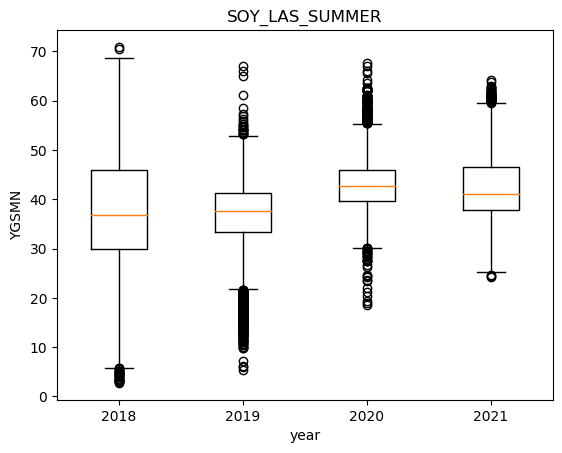

In [54]:
trait = 'result_YGSMN'

trait_data = []

for yr in input_years_as_int:
    df_yr = df_piv[(df_piv['analysis_year'] == yr)]
    trait_data.append(df_yr[df_yr[trait].notna()][trait])
    
plt.figure()
plt.boxplot(trait_data, positions=input_years_as_int);
#plt.ylim([-10,10])
plt.ylabel('YGSMN')
plt.xlabel('year')
plt.title(DKU_DST_ap_data_sector)
plt.show()

In [55]:
### train model.
grouping_cols = predictive_advancement_lib.get_grouping_cols_per_sector(analysis_sector=DKU_DST_ap_data_sector)
grouping_cols.remove('current_stage')
df_piv_grouped = df_piv.groupby(by=grouping_cols)

In [56]:
def stratified_train_test_split(df_in, out_col):
    df_tr_list = []
    df_te_list = []
    
    for out_val in pd.unique(df_in[out_col]):
        df_in_val = df_in[df_in[out_col] == out_val]
        df_tr_val, df_te_val = train_test_split(df_in_val, test_size=0.2)
        df_tr_list.append(df_tr_val)
        df_te_list.append(df_te_val)
        
    df_tr = pd.concat(df_tr_list,axis=0)
    df_te = pd.concat(df_te_list,axis=0)
    
    return df_tr, df_te


In [57]:
for index, df_use in df_piv_grouped:  # build model per unique combination of grouping_cols; stage currently
    # get model parameters for this sector and stage
    args = []
    # model parameters
    # extract inputs from args
    # get input and output column names
    mdl_in_cols = []
    mdl_in_cols.extend(['result_diff_' + trait for trait in numeric_diff_traits])
    mdl_in_cols.extend(['result_' + trait for trait in numeric_raw_traits])

    cols_to_norm = []
    mdl_out_col = 'was_adv'

    # get parameters for xgboost models
    xgb_params_class = predictive_advancement_lib.XGBoostModelParameters(
        max_depth=5,
        reg_lambda=100,
        subsample=0.2,
        learning_rate=0.005,
        n_estimators=500
    )

    # make sure each column in mdl_in col is also in the dataframe
    mdl_in_cols_use = mdl_in_cols.copy()
    for col in mdl_in_cols:
        if col not in df_use.columns:
            mdl_in_cols_use.remove(col)
    mdl_in_cols = mdl_in_cols_use
        
    # if the output var is not a boolean, this causes problems. check
    if not isinstance(df_use[mdl_out_col].dtype, bool):
        df_use[mdl_out_col] = df_use[mdl_out_col].astype(bool)

    preproc_class = predictive_advancement_lib.PredAdvPreprocessor(
        preprocess_steps=[]
    )

    mdl_class = predictive_advancement_lib.PredAdvMdl(
        params=xgb_params_class.params,
        in_cols=mdl_in_cols,
        out_col=mdl_out_col,
        weight_by_col=False
    )
  
    df_tr, df_te = stratified_train_test_split(df_use, out_col='was_adv')
    df_tr_proc = preproc_class.train_preprocessing(df_tr)
    
    # update mdl in cols based on preprocessing steps
    if 'process rm' in preproc_class.preprocess_steps:
        mdl_class.in_cols.append('rm_estimate_proc')
        # if there are dummy vars added to df_use_proc due to processing text traits, add to mdl in cols
    if 'process text traits' in preproc_class.preprocess_steps:
        new_cols = list(set(df_tr_proc.columns).difference(set(df_use.columns)))
        if 'process rm' in preproc_class.preprocess_steps:
            mdl_class.in_cols.remove('rm_estimate_proc')
        mdl_class.in_cols.extend(new_cols)
    if 'get qualifiers' in preproc_class.preprocess_steps:
        cols_to_append = df_tr_proc.columns[['qualifiers_' in col for col in df_tr_proc.columns]]
        mdl_in_cols.extend(cols_to_append)

    mdl_class.train_mdl(df_tr_proc);
    df_tr_proc['recommendation_score'] = mdl_class.predict_proba(df_tr_proc)
    df_input_stats = performance_validation_lib.compute_input_statistics(
        df_in=df_tr_proc,
        in_cols=mdl_class.in_cols
    )
    # get predictions, print metrics on training dataset (not representative of performance).
    print("Train:",index,df_tr_proc.shape,mdl_class.score(df_tr_proc, df_tr_proc[mdl_out_col].values))
    
    # some validation metrics:    
    df_te_proc = preproc_class.train_preprocessing(df_te)
    print("Test",index,df_te_proc.shape,mdl_class.score(df_te_proc, df_te_proc[mdl_out_col].values))

Mean of empty slice
All-NaN slice encountered
Degrees of freedom <= 0 for slice.
All-NaN slice encountered
All-NaN slice encountered
All-NaN slice encountered


Train: SOY_LAS_SUMMER (16866, 95) (0.8520404956854537, array([[0.87128185, 0.12871815],
       [0.16720085, 0.83279915]]), 0.9312114803186232, 0.5816079089722067)
Test SOY_LAS_SUMMER (4218, 94) (0.8340393259097949, array([[0.87703388, 0.12296612],
       [0.20895522, 0.79104478]]), 0.920677923494595, 0.5703305149884704)


In [58]:
#shap code for new class method
# get and plot shapley values after training a model
do_shap = 0
if do_shap == 1:
    import shap
    x = df_te_proc[mdl_class.in_cols].values.astype(float)
    shap_input = shap.utils.sample(x, np.minimum(x.shape[0],1000))
    explainer = shap.Explainer(mdl_class.mdl.predict_proba, shap_input)
    shap_values = explainer(shap_input)
    shap_values = shap_values[:,:,1]

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='bar')

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='dot')

#for idx in range(len(mdl_class.in_cols)):
#    notnan_mask = np.isnan(shap_input[:,idx])==False
#    if np.sum(notnan_mask) > 10:
#        shap.plots.partial_dependence(idx,mdl_class.mdl.predict,shap_input[notnan_mask,:],ice=False,feature_names=mdl_class.in_cols)

# some useful shapley/interpolation related code
#plt.plot(shap_values[:,0].data, shap_values[:,0].values,'.')
#shap.plots.scatter(shap_values[:,5])

In [59]:
# make sure advancement columns are boolean
df_input = df_te_proc.copy()
df_input['recommendation_score'] = mdl_class.predict_proba(df_input)
if 'was_adv' in df_input.columns:
    df_input['was_adv'] = df_input['was_adv'].astype(bool)
if 'was_adv_next' in df_input.columns:
    df_input['was_adv_next'] = df_input['was_adv_next'].astype(bool)

# set trait column and yield column based on data sector
trait_prefix = 'result_' # this gets both result_ and result_diff cols
yield_col = 'result_diff_YGSMN'

# compute metrics for each stage
adv_metrics_all = []
trait_metrics_all = []

for stg in pd.unique(df_input['current_stage']):
    df_use = df_input[df_input['current_stage'] == stg]
    df_use['random_nums'] = np.random.rand(df_use.shape[0], 1)
    adv_metrics, trait_metrics = performance_validation_lib.compute_model_metrics(
        df_use,
        compute_advancement_metrics=True,
        yield_col=yield_col,
        trait_prefix=trait_prefix
    )
    adv_metrics['stage'] = stg
    trait_metrics['stage'] = stg

    adv_metrics_all.append(adv_metrics)
    trait_metrics_all.append(trait_metrics)

# join across stages
df_adv_metrics = pd.concat(adv_metrics_all,axis=0)
df_trait_metrics = pd.concat(trait_metrics_all,axis=0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
All-NaN slice encountered
Mean of empty slice
Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.
